TODO Jack:


*   scaricato il dataset, si dovrebbe prendere test, train, val ed univerli "normal-penuomia", fare lo shuffle e creare le coppie immagini-label -> creare un'altra director "chest_ray_shuffled con "test, train, val". Come label si potrebbe semplicemente rinominare l'immagine come \<label\>\_\<test/train/val\>\<numeric_id\>. esempio normale_test_00001
*   eliminare il vecchio "chest_ray" directory che contiene le immagini non mischiate ( per motivi di memoria ). con `! rm -rf /content/chest_ray`
*   provare a creare l'oggetto dataset "ChestRay_DataModule"
*   provare a creare l'oggetto architettura "JAM"
*   vedere se una immagine ed un batch viene parsata dalla rete


TODO Max:
* Effettuare vari preprocessing (data augmentation, he, he + gaussian blur, heatmap, downsampling)
* Scegliere una colormap per la [heatmap](https://www.shutterstock.com/image-vector/heat-map-abstract-infrared-thermographic-260nw-2239656403.jpg) , ce ne sono varie, alcune fanno "peggio" ed altre vanno bene. Oppure scegliere un preprocessing in generale.
* Data exploration: plot grafico a torta train/test, plot histogram of an image
* Errore KAN come utilizzare la kan ( da error )



# INSTALLATION

In this section there are the installation needed for the rest of the code:

1. *gdown* : This package is used for downloading files from Google Drive. It's handy for fetching data or models stored on Google Drive links.

2. *tqdm* : This package provides a progress bar for iterables (like loops or file downloads) in Python. It makes it easier to track the progress of lengthy operations.

3. *pytorch_ligthning* : This is a high-level interface for PyTorch that makes it easier to train complex models. It provides abstractions and utilities for training neural networks.

4. *torchvision* : This package provides popular datasets, model architectures, and image transformations for computer vision tasks in PyTorch.

5. *wget* : This package is used for programmatically downloading files from the internet using HTTP or FTP protocols.

6. *pykan* : This package is needed for the implementation of the KAN networks

In [1]:
%%capture
!pip install gdown tqdm
!pip install pytorch_lightning torchvision --quiet
!pip install pykan

# IMPORT OF LIBRARIES

In this section there is the libraries import:

1. *numpy* : This library is used for numerical computations and array manipulations in Python.


2. *torch* : this library is widely used for building and training deep learning models. In particular **torch.nn** is the neural network module used for building and training neural networks

3. *torch.utils.data* :

*   **random_split**: A utility function from PyTorch for splitting datasets into random subsets, commonly used for creating train/validation/test splits.

* **DataLoader**: Used for creating batches of data that can be fed into the neural network during training.

* **Dataset**: The base class for all datasets in PyTorch. You can create custom datasets by subclassing Dataset and implementing methods like __len__ and __getitem__.

4. *kan* : This is the library used to define the Kolgmorov-Arnold Networks

5. *cv2* : Importing OpenCV, a popular library for computer vision tasks such as image processing, video capture, and computer vision algorithms.

6. *PIL* : Importing the Python Imaging Library (PIL), which provides support for opening, manipulating, and saving many different image file formats.

7. *matplotlib* : Importing matplotlib's pyplot module, commonly used for plotting and visualizing data.

8. *os* : Standard library for interacting with the operating system, used here for file and directory operations.

9. *google.colab* : Importing a module from Google Colab, a cloud-based Python environment, which allows you to mount Google Drive for accessing files stored there.


In [22]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import random_split, DataLoader, Dataset

import pytorch_lightning as pl

from kan import KAN

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import os
import gdown
import zipfile
from tqdm.notebook import tqdm
from google.colab import drive

# GLOBAL DEFINITIONS

Global variables where there are stored hyperparameters for the training and link, paths for the dataset.

In [3]:
global_var = {
    # Dataset
    'link_download_prefix' : 'https://drive.google.com/uc?export=download&id=YOUR_FILE_ID', # Generic link to download from Drive the file with id "YOUR_FILE_ID"
    "link_dataset": "https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0", # The ID is "10un_W7teXQy9LOB1uqd0e6VJ46UFNRza" of the file
    "path_download_dataset": "/content/dataset.zip", # Path of the runtime directory of Colab with the zipped dataset
    "extract_directory": "/content", # Directory where we want to extract the zipped dataset
    "dataset_name": "chest_xray", # Name of the dataset

    # Train
    'batch_size': 32,
    'hidden_dim': 8,
    'epochs': 10

    # hyperparamter search
}

## Color Class
This class is used for printing text in different color. In particular each attribute in the Color class corresponds to a specific text color or formatting style.

In [4]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m' #RESET: Resets all text formatting and color to default
    BOLD = '\033[1m' #BOLD: Makes the text bold
    UNDERLINE = '\033[4m' #UNDERLINE: Underlines the text

Random Seed

In [5]:
# Set randomness always the same at each run
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

# FUNCTION DEFINITION

## Download Dataset
The function, given the link of the dataset in google drive, download it.

Args:
        
1.   **link_dataset** = link to zip files
2.   **delete_zip_file** = {True/False}, use to remove the zip file once extracted the content

Note: the link my be public or gdown can't download it

Some comments:

1. id_dataset = link_dataset.split("/view")[0].split("/")[-1] :

This instruction take the link of the dataset on Drive that contain the ID = **10un_W7teXQy9LOB1uqd0e6VJ46UFNRza**

Initial Link Dataset:

*https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0*

After the first split (before and after the word /view we will have:

link_dataset.split("/view")[0] :

*https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza*

link_dataset.split("/view")[1] :

*?usp=drive_link0*

Then we take the first part [0] and we split using the "/":

link_dataset.split("/view")[0].split("/")[0]:

*https://drive.google.com/file/d*

link_dataset.split("/view")[0].split("/")[1]:

*10un_W7teXQy9LOB1uqd0e6VJ46UFNRza*

Finally with [-1] we extract the last element (the [1]) of the list, that it's the ID:

*10un_W7teXQy9LOB1uqd0e6VJ46UFNRza*






In [6]:
def download_dataset(link_dataset, delete_zip_file=False):

    # Creating string for download

    link_download_base =  global_var['link_download_prefix'] # General link for the download from Drive (with "YOUR_FILE_ID")
    id_dataset = link_dataset.split("/view")[0].split("/")[-1]
    dataset_download_link = link_download_base.replace("YOUR_FILE_ID", id_dataset) # Replace the "YOUR_FILE_ID" part with the extracted id_dataset

    path_download_dataset = global_var['path_download_dataset'] # Path of the zip file that contain the dataset
    dataset_name = global_var['dataset_name'] # Dataset's Name
    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset

    # Downloading zip file
    try:
        if not( os.path.exists(dataset_name) ): # check is the dataset is already downloaded
            gdown.download(
                url=dataset_download_link, # Link that we extract with the file ID
                output=path_download_dataset, # Path of the runtime Colab to save the zip file
                quiet=False # Output to check the download
            )
            print(f"{Color.GREEN}\nZip file downloaded{Color.RESET}")
        else:
            print(f"{Color.GREEN}Zip file already downloaded{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Download went wrong!\nerror:{Color.RESET}")
        print(error)


    # Unzipping the file
    '''
    In this part we want to unzip the zip file contain the dataset
    '''
    try:
        if not( os.path.exists(dataset_name) ):

          # This open the file zip in path_download_dataset in 'r' = read mode.
          # The file is created from the ZipFile class contained in zipfile module
          # and the name of the instance will be zipfile

            with zipfile.ZipFile(path_download_dataset, 'r') as zip_file:

                n_files = len(zip_file.namelist()) # number of files and directories inside the zip

                with tqdm(total=n_files, desc='Unzipping files') as pbar: # It's a bar to track the unzip process, we pass the number of total files
                    for file_name in zip_file.namelist():
                        zip_file.extract(member=file_name, path=extract_directory) # Extract the file_name (iteration over all the files) in the path extract_directory
                        pbar.update(1) # increment the progress bar of 1 unit for each extraction

            print(f"{Color.GREEN}Dataset {dataset_name} unzipped{Color.RESET}")
        else:
            print(f"{Color.GREEN}Dataset {dataset_name} already unzipped{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Unzip went wrong!\nerror:{Color.RESET}")
        print(error)

    # Removing zip file
    '''
    In this part we remove the zip file if the flag
    delete_zip_file is True (args of the function)
    '''
    try:
        if delete_zip_file == True:
            ! rm {path_download_dataset}
            print(f"{Color.GREEN}File {path_download_dataset} removed{Color.RESET}")
    except Exception as error:
        print(f"{Color.RED}Could not remove zip file, pass!\nerror:{Color.RESET}")
        print(error)
        pass

## Merge Dataset

Given the dataset, it merge and shuffle it.

Args:
1. **dataset_directory** = where to create the shuffled dataset
        
2. **dataset_name_original** = name of directory where is stored the dataset
        
3. **dataset_name_new** = name where to store dataset


In [7]:
def merge_dataset():

    dataset_name = global_var['dataset_name']
    extract_directory = global_var['extract_directory']
    current_path = os.path.join(extract_directory, dataset_name)

    sub_directory = [ os.path.join(current_path, s) for s in ['train', 'test', 'val']]
    classes = ['PNEUMONIA', 'NORMAL']

    try:
        for sub_dir in sub_directory:

            for c in classes:
                sub_dir_c = os.path.join(sub_dir, c)
                counter = 0

                for img_name in os.listdir(sub_dir_c):
                    counter += 1

                    img_no_c = img_name.replace(c+"/", "")
                    current_name = img_no_c.split("/")[-1]
                    new_name = sub_dir.split("/")[-1] + "_" + c.lower() + f"_{counter:05d}" + "." + current_name.split(".")[-1]

                    final_path = sub_dir + "/" + img_no_c.replace(current_name, new_name)

                    os.rename( os.path.join(sub_dir_c, img_name), final_path )

                ! rmdir {sub_dir_c}
    except Exception as error:
        print(f"Dataset already merged\n")
        pass


## Setup Device

In [8]:
def setup_device():

    """
    Setup device to be used
    """

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Current device: {device}")

## Get Heatmap

Given the path for an image, extract a colormap to highlight details

Args:

1. img_path: path to the image


Colormap documentation:

https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html


In [9]:
def get_heatmap(img_path):


    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_colored = cv2.applyColorMap(img_normalized, cv2.COLORMAP_TWILIGHT)
    img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

    return img_rgb

In [10]:
def counter (path_dir, labels = True):

  file_list = os.listdir(path_dir) # Create a list of all files in the dataset directory

  if labels == True:

    train_count_normal = 0 # Counter of images "normal"
    train_count_pneumonia = 0 # Counter of images "pneumonia"

  # Iterate through each file in the directory
    for filename in file_list:
        if 'normal' in filename:
            train_count_normal += 1
        elif 'pneumonia' in filename:
            train_count_pneumonia += 1
    counts = [train_count_normal, train_count_pneumonia]

    return train_count_normal, train_count_pneumonia

  else:

    samples_num = len(file_list);
    return samples_num


In [11]:
def histogram_plot(classes, counts, colors):

  plt.figure(figsize=(8, 6))
  plt.bar(classes, counts, color = colors)
  plt.title('Histogram Distribution')
  plt.xlabel('Class')
  plt.ylabel('Number of samples')
  plt.show()






# DATASET EXPLORATION


Fare plot dataset etc, ...

## Dataset Classes

ChestRayDataset

In [12]:
class ChestRayDataset(Dataset):

    def __init__(self,file_path, transform):
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.file_path))

    def __getitem__(self, index):
        sample = self.file_path + "/" + os.listdir(self.file_path)[index]
        #sample =
        label = sample.split("/")[-1].split("_")[1]

        #sample = self.transform(sample)
        return sample,label

Reference https://lightning.ai/docs/pytorch/stable/data/datamodule.html


In [13]:
class ChestRay_DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        #self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download dataset -> not needed
        return

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
           chest_ray_train = None

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.chest_ray_test = None #MNIST(self.data_dir, train=False, transform=self.transform)

        if stage == "predict":
            self.chest_ray_predict =None #MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.chest_ray_train, batch_size=32)

    def val_dataloader(self):
        return DataLoader(self.chest_ray_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.chest_ray_test, batch_size=32)

    def predict_dataloader(self):
        return DataLoader(self.chest_ray_test, batch_size=32) # Test?

# TRAINING

Reference: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

Queste cose sono solo abbozzate, copia ed incolla dal sito e riscritte

In [14]:
class JAM_network(pl.LightningModule):
    def __init__(self, input_dim):
        super(JAM_network,self).__init__()

        # insert layer, etc ...

    def forward(network_input):
        return network_input

In [15]:
class JAM(pl.LightningModule):
    def __init__(self, vocab_size):
        super(JAM).__init__()
        self.model = JAM_network(0)

        # insert metric, fnc_loss


    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs, target)
        loss = torch.nn.functional.nll_loss(output, target.view(-1))
        return loss

    def validation_step(self, batch):
        loss = 0
        return loss

    def test_step(self, batch):
        loss = 0
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

# MAIN

##  DOWNLOAD AND MERGE OF THE DATASET

In [16]:
download_dataset(
     link_dataset=global_var['link_dataset'],
     delete_zip_file=True
 )

merge_dataset()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza
From (redirected): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza&confirm=t&uuid=b8a35835-1fb9-457a-b841-7355531a0b65
To: /content/dataset.zip
100%|██████████| 2.46G/2.46G [00:40<00:00, 60.6MB/s]



Zip file downloaded


Unzipping files:   0%|          | 0/17591 [00:00<?, ?it/s]

Dataset chest_xray unzipped
File /content/dataset.zip removed


## DATASET EXPLORATION

The number of "normal" images: 1341
The number of "pneumonia" images: 3875
The number of training images: 5216
The number of test images: 624
The number of validation images: 16
torch.Size([3, 1465, 1658])
torch.Size([1, 3, 1465, 1658])
torch.Size([3, 800, 800])


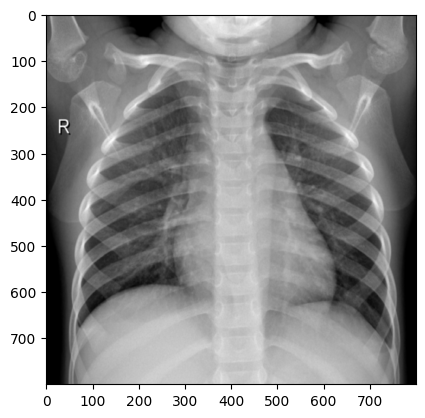

label: normal
image: /content/chest_xray/train/train_normal_00770.jpeg


In [62]:
# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Instance of classes for the Dataset
train_dataset = ChestRayDataset(path_training_set) # Create an instance of training class
test_dataset = ChestRayDataset(path_test_set) # Create an instance of test class
val_dataset = ChestRayDataset(path_val_set) # Create an instance of validation class

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set, labels = True); # Count the number of normal images and pneumonia images

# Histogram plot
classes = ['Normal', 'Pneumonia']  # List of class labels
counts = [train_norm, train_pneu]  # List of counts corresponding to each class
colors = ['aquamarine', 'blue']  # List of colors corresponding to each bar
#histogram_plot(classes = classes, counts = counts, colors = colors)

print("The number of \"normal\" images:", train_norm)
print("The number of \"pneumonia\" images:", train_pneu)

# Counting the number of total images in the Training, Test and Validation Set
train_num = counter(path_training_set, labels = False);
test_num = counter(path_test_set, labels = False);
val_num = counter(path_val_set, labels = False);

# Histogram plot
classes = ['Train', 'Test', 'Validation']  # List of class labels
counts = [train_num, test_num, val_num]  # List of counts corresponding to each class
colors = ['violet', 'pink', 'rebeccapurple']  # List of colors corresponding to each bar
#histogram_plot(classes = classes, counts = counts, colors = colors)

print("The number of training images:", train_num)
print("The number of test images:", test_num)
print("The number of validation images:", val_num)

# Generate a random number to select a random image from training set
random_num = 0# np.random.randint(1, len(train_dataset))
img, label = train_dataset[random_num] # Take an image + label randomly

# Load the image using cv2 library
rand_img = cv2.imread(img)

# Convert BGR image to RGB (opencv uses BGR by default)
img_rgb = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
tr = transforms.Compose([transforms.ToTensor(),
                         transforms.GaussianBlur(5, sigma=(80, 80))]
                        )

img_rgb = tr(img_rgb) #.to(torch.uint8)
#img_rgb = transforms.functional.equalize(img_rgb)
print(img_rgb.shape)
print(img_rgb.unsqueeze(0).shape)
img_rgb = nn.functional.interpolate( img_rgb.unsqueeze(0), size=(800, 800), mode='nearest')

print(img_rgb.squeeze(0).shape)
# Display the image using matplotlib library
plt.imshow(img_rgb.squeeze(0).permute(1, 2, 0))
plt.axis('on')  # Turn off axes
plt.show()

print(f"label: {label}")
print(f"image: {img}")


## PREPROCESSING

In this part we will do some preprocessing techinique on the data:

1. Data

In [18]:
setup_device()

Current device: cpu


pneumonia
(1152, 1500)


(-0.5, 1499.5, 1151.5, -0.5)

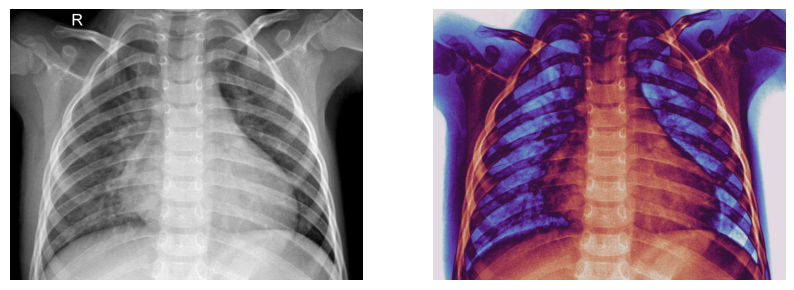

In [69]:
normal_img_path, label_1  = train_dataset[667] #"chest_xray/test/train_normal_00001.jpeg"
print(label_1)
normal_img = Image.open(normal_img_path)
normal_img = np.array(normal_img)
print(normal_img.shape)
processed_img = get_heatmap(normal_img_path) # Ci sono altri tipi ti filtri per fare l'highlight ( fatto per bene ), ne ho scelto uno

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normal_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')

normal


(-0.5, 1657.5, 1464.5, -0.5)

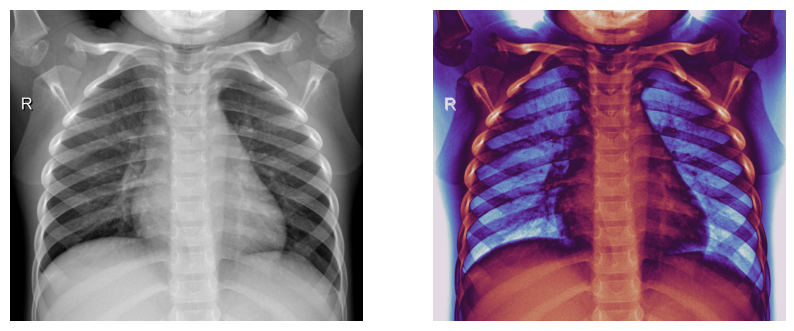

In [63]:
normal_img_path, label_2  = train_dataset[0] # "chest_xray/test/test_pneumonia_00019.jpeg"
print(label_2)
normal_img = Image.open(normal_img_path)
normal_img = np.array(normal_img)
processed_img = get_heatmap(normal_img_path)

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normal_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')